In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import torchvision.transforms as transforms
from scipy import misc

import os
from tqdm import tqdm 

In [3]:
# the folder from test.zip file
dir_test = 'D:\\dataset\\256_ObjectCategories'

# Collect metadata

In [4]:
subdirs = list(os.walk(dir_test))[1:]

# collect train metadata
test_metadata = []

for dir_path, _, files in tqdm(subdirs):
    dir_name = dir_path.split('\\')[-1]
    
    for file_name in files:
        if not file_name.startswith('.'):
            #read image
            temp = misc.imread(os.path.join(dir_path, file_name))
            #collect image metadata
            image_metadata = []
            image_metadata.extend([dir_name, file_name])
            image_metadata.extend(
                list(temp.shape) if len(temp.shape) == 3
                else [temp.shape[0], temp.shape[1], 1]
            )
            image_metadata.extend([temp.nbytes, temp.dtype])
            #append image metadata to list
            test_metadata.append(image_metadata)
            



  0%|          | 0/257 [00:00<?, ?it/s]C:\Users\46029\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':
100%|██████████| 257/257 [00:41<00:00,  6.18it/s]


# Explore metadata

In [5]:
M = pd.DataFrame(test_metadata)
M.columns = ['directory', 'img_name', 'height', 'width', 'channels', 'byte_size', 'bit_depth']
M['img_extension'] = M['img_name'].apply(lambda x: x.split('.')[-1])
M.to_csv('test.csv', index=False)

In [6]:
# number of grayscale images
(M.channels != 3).sum()

422

In [7]:
M.img_extension.unique()

array(['jpg'], dtype=object)

In [8]:
M.bit_depth.unique()

array([dtype('uint8')], dtype=object)

# Resize images

In [9]:
test_transform = transforms.Compose([
    transforms.Scale(224, Image.LANCZOS),
    transforms.CenterCrop(224)
])

C:\Users\46029\AppData\Local\Programs\Python\Python35\lib\site-packages\torchvision\transforms\transforms.py:211: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [10]:
n_images = len(M)
n_images

30607

In [11]:
images = np.zeros((n_images, 224, 224, 3), dtype='uint8')
numbers = np.zeros((n_images,), dtype='S8')

In [12]:
# resize RGB images
for i, row in tqdm(M.loc[M.channels == 3].iterrows()):
    # get image
    file_path = os.path.join(dir_test, row.directory, row.img_name)
    image = Image.open(file_path)
    
    # transform it
    image = test_transform(image)
    
    # convert to array
    array = np.asarray(image, dtype='uint8')
    
    images[i] = array
    numbers[i] = row.img_name[:-4]

30185it [01:48, 277.95it/s]


In [13]:
# resize grayscale images
for i, row in tqdm(M.loc[M.channels == 1].iterrows()):
    file_path = os.path.join(dir_test, row.directory, row.img_name)
    image = Image.open(file_path)
    
    # transform it
    image = test_transform(image)
    
    # convert to array
    array = np.asarray(image, dtype='uint8')
    
    # convert to RGB
    array = np.stack([array, array, array], axis=2)
    images[i] = array
    numbers[i] = row.img_name[:-4]

422it [00:01, 385.70it/s]


# Show some resized images

In [14]:
# choose random images
to_show = np.random.choice(np.arange(0, n_images), size=2*4)

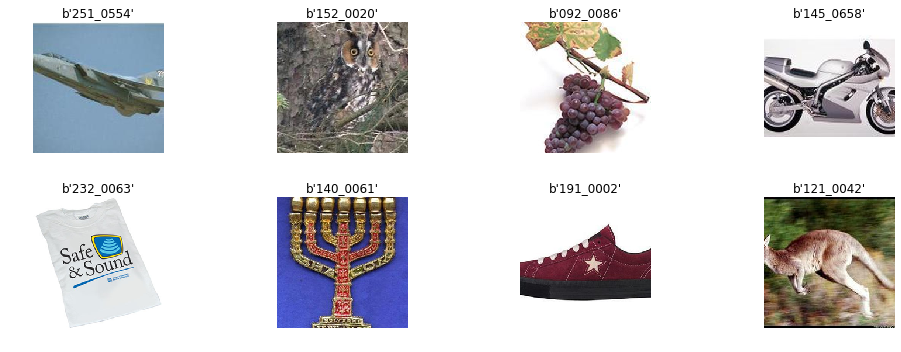

In [15]:
_, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 5))
axes = axes.flatten()
for i, j in enumerate(to_show):
    axes[i].set_axis_off();
    axes[i].imshow(images[j]/255);
    axes[i].set_title(numbers[j]);
plt.tight_layout()

# Save

In [16]:
np.save('data/test_images.npy', images) # size: 1.1 GB
np.save('data/test_file_names.npy', numbers)